In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
data = fetch_openml(name='credit-g', version=1, as_frame=True)
df = data.frame

X = df.drop('class', axis=1)
y = df['class'].map({'good': 0, 'bad': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [3]:
best_model = joblib.load("best_credit_model.pkl")

In [4]:
preprocessor = best_model.named_steps['preprocessing']
classifier = best_model.named_steps['classifier']

feature_names = preprocessor.get_feature_names_out()

In [5]:
importances = classifier.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_importance_df.head(10)

,Feature,Importance
1,num__credit_amount,0.340829
4,num__age,0.249704
0,num__duration,0.183778
3,num__residence_since,0.077387
2,num__installment_commitment,0.072547
5,num__existing_credits,0.044794
6,num__num_dependents,0.030961


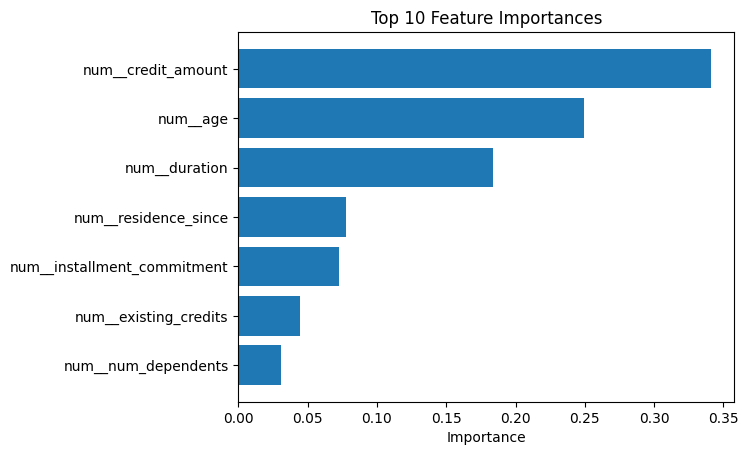

In [6]:
top_features = feature_importance_df.head(10)

plt.figure()
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.show()

In [7]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


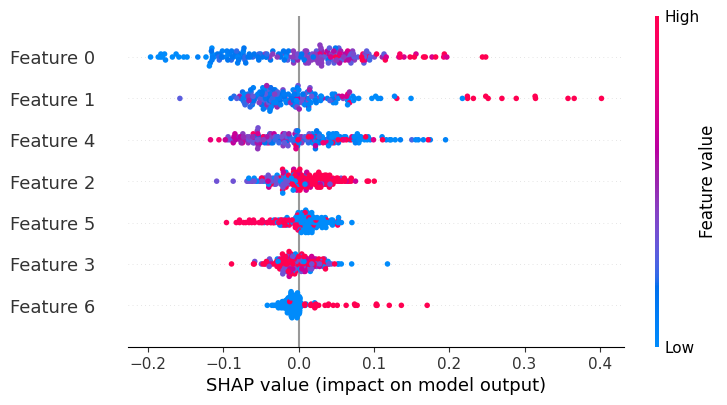

In [16]:
import shap
import numpy as np

# Extract steps
preprocessor = best_model.named_steps['preprocessing']
classifier = best_model.named_steps['classifier']

# Transform test data
X_test_transformed = preprocessor.transform(X_test)

# Convert sparse → dense
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# Use modern SHAP API
explainer = shap.Explainer(classifier)

shap_values = explainer(X_test_transformed)

# 🔥 Plot correctly for binary classification
shap.plots.beeswarm(shap_values[:, :, 1])

In [8]:
def predict_credit_risk(input_data):
    """
    input_data: dictionary of feature values
    """
    input_df = pd.DataFrame([input_data])
    prediction = best_model.predict(input_df)[0]
    probability = best_model.predict_proba(input_df)[0][1]
    
    return {
        "prediction": int(prediction),
        "default_probability": float(probability)
    }

In [9]:
joblib.dump(best_model, "production_credit_model.pkl")
print("Production model saved!")

Production model saved!
